In [1]:
import os
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from src.dataset import *
from src.model import *

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [2]:
config = {
    'local_depth': 8,
    'local_convdepth': 16,
    'local_imagesize': 256,
    'global_depth': 5,
    'global_convdepth': 32,
    'global_imagesize': 128,
    'scale': 0.25}

model = CIEXYZNet(**config)
if os.path.exists("model_weights/model.index"):
    model.load_weights("model_weights/model")

2022-06-06 02:54:03.312485: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:938] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0d:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-06-06 02:54:03.338399: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:938] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0d:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-06-06 02:54:03.338671: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:938] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0d:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-06-06 02:54:03.338980: I tensorflow/core/platform/cpu_feature_guard.cc:152] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with t

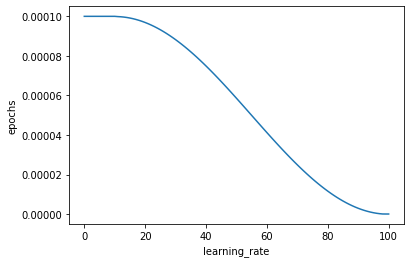

In [3]:
BATCH_SIZE = 4
EPOCHS = 100
LR = 1e-4
WEIGHT = 1.5

schedule = CosineDecayWithWarmup(
    epochs=EPOCHS,
    lr_max=1e-4,
    lr_min=1e-7,
    sustain_epochs=10)

schedule.plot()

optimizer = tf.keras.optimizers.Adam(schedule)

xyz_loss_fn = tf.keras.losses.MeanAbsoluteError()
srgb_loss_fn = tf.keras.losses.MeanAbsoluteError()
xyz_metric_fn = tf.keras.metrics.Mean()
srgb_metric_fn = tf.keras.metrics.Mean()
total_metric_fn = tf.keras.metrics.Mean()

train_dataset = DataLoader(train_set="training", batch_size=BATCH_SIZE, image_size=256)
val_dataset = DataLoader(train_set="validation", batch_size=BATCH_SIZE, image_size=256)
test_dataset = DataLoader(train_set="testing", batch_size=BATCH_SIZE, image_size=256)

train_steps = len(train_dataset)

In [ ]:
history_path = "history/history.json"
if os.path.exists(history_path):
    with open(history_path, "r") as f:
        history = json.load(f)
    best_val = min(history['val_xyz_loss'])
else:
    history = {
        'loss': [], 
        'xyz_loss': [], 
        'srgb_loss': [], 
        'val_loss': [],
        'val_xyz_loss': [],
        'val_srgb_loss': []}
    best_val = np.inf

current_epoch = len(history['loss'])
for epoch in range(current_epoch+1, EPOCHS+1):
    print(f"Epoch {epoch}/{EPOCHS}")
    progbar = tf.keras.utils.Progbar(
        train_steps, interval=0.05,
        stateful_metrics=[
            'loss', 
            'xyz_loss', 
            'srgb_loss', 
            'val_loss', 
            'val_xyz_loss', 
            'val_srgb_loss'])
    for step, train_batch in enumerate(train_dataset.data):
        sRGB_image = train_batch['sRGB_image']
        XYZ_image = train_batch['XYZ_image']
        with tf.GradientTape() as tape:
            train_logits = model(sRGB_image, training=True)
            xyz_logits, srgb_logits = train_logits
            xyz_loss = xyz_loss_fn(XYZ_image, xyz_logits)
            srgb_loss = srgb_loss_fn(sRGB_image, srgb_logits)
            total_loss = (xyz_loss * WEIGHT) + srgb_loss

        grads = tape.gradient(total_loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        xyz_metric_fn.update_state(xyz_loss)
        srgb_metric_fn.update_state(srgb_loss)
        total_metric_fn.update_state(total_loss)

        train_xyz_mae = xyz_metric_fn.result().numpy()
        train_srgb_mae = srgb_metric_fn.result().numpy()
        train_total_mae = total_metric_fn.result().numpy()

        progbar.update(
            step, 
            values=[
                ('loss', train_total_mae), 
                ('xyz_loss', train_xyz_mae), 
                ('srgb_loss', train_srgb_mae)], 
            finalize=False)
    
    xyz_metric_fn.reset_state()
    srgb_metric_fn.reset_state()
    total_metric_fn.reset_state()
    
    for val_batch in val_dataset.data:
        sRGB_image = val_batch['sRGB_image']
        XYZ_image = val_batch['XYZ_image']
        val_logits = model(sRGB_image)
        xyz_logits, srgb_logits = val_logits
        xyz_loss = xyz_loss_fn(XYZ_image, xyz_logits)
        srgb_loss = srgb_loss_fn(sRGB_image, srgb_logits)
        total_loss = (xyz_loss * WEIGHT) + srgb_loss
        xyz_metric_fn.update_state(xyz_loss)
        srgb_metric_fn.update_state(srgb_loss)
        total_metric_fn.update_state(total_loss)

    val_xyz_mae = xyz_metric_fn.result().numpy()
    val_srgb_mae = srgb_metric_fn.result().numpy()
    val_total_mae = total_metric_fn.result().numpy()

    values = {
        'loss': train_total_mae, 
        'xyz_loss': train_xyz_mae,
        'srgb_loss': train_srgb_mae,
        'val_loss': val_total_mae,
        'val_xyz_loss': val_xyz_mae,
        'val_srgb_loss': val_srgb_mae}
    progbar.update(train_steps, values=values.items(), finalize=True)
    
    xyz_metric_fn.reset_state()
    srgb_metric_fn.reset_state()
    total_metric_fn.reset_state()

    history['loss'].append(np.float64(train_total_mae))
    history['xyz_loss'].append(np.float64(train_xyz_mae))
    history['srgb_loss'].append(np.float64(train_srgb_mae))
    history['val_loss'].append(np.float64(val_total_mae))
    history['val_xyz_loss'].append(np.float64(val_xyz_mae))
    history['val_srgb_loss'].append(np.float64(val_srgb_mae))

    with open(history_path, "w") as f:
        json.dump(history, f, indent=4)

    if best_val > val_xyz_mae:
        best_val = val_xyz_mae
        model.save_weights("model_weights/model")
        print("Model improved and saved")

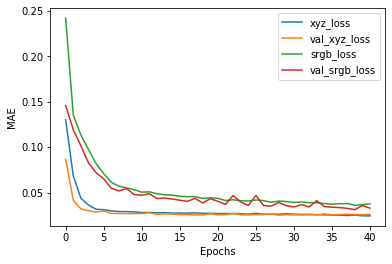

In [4]:
history = pd.read_json("history/history.json", orient="column")

plt.plot(history['xyz_loss'], label='xyz_loss')
plt.plot(history['val_xyz_loss'], label='val_xyz_loss')
plt.plot(history['srgb_loss'], label='srgb_loss')
plt.plot(history['val_srgb_loss'], label='val_srgb_loss')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

# Evaluation

In [5]:
for test_batch in test_dataset.data:
    sRGB_image = test_batch['sRGB_image']
    XYZ_image = test_batch['XYZ_image']
    test_logits = model(sRGB_image)
    xyz_logits, srgb_logits = test_logits
    xyz_loss = xyz_loss_fn(XYZ_image, xyz_logits)
    srgb_loss = srgb_loss_fn(sRGB_image, srgb_logits)
    total_loss = (xyz_loss * WEIGHT) + srgb_loss
    xyz_metric_fn.update_state(xyz_loss)
    srgb_metric_fn.update_state(srgb_loss)
    total_metric_fn.update_state(total_loss)

print("Total loss:", total_metric_fn.result().numpy())
print("XYZ loss:", xyz_metric_fn.result().numpy())
print("sRGB loss:", srgb_metric_fn.result().numpy())

2022-06-06 02:54:08.748788: I tensorflow/stream_executor/cuda/cuda_dnn.cc:379] Loaded cuDNN version 8400
2022-06-06 02:54:09.780540: I tensorflow/stream_executor/cuda/cuda_blas.cc:1804] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


Total loss: 0.07481698
XYZ loss: 0.026401022
sRGB loss: 0.035215445


## sRGB

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Filename: a1933-kme_244.JPG


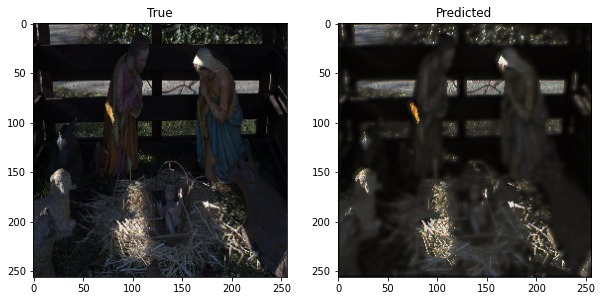

Filename: a1683-kme_028.JPG


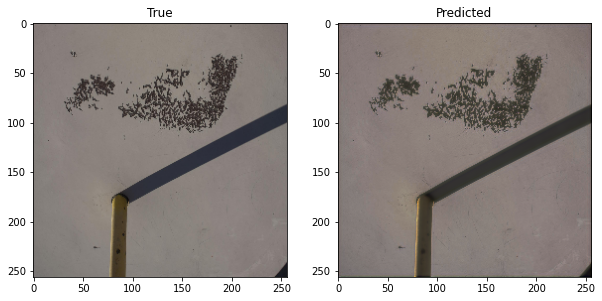

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Filename: a0565-NKIM_MG_6637.JPG


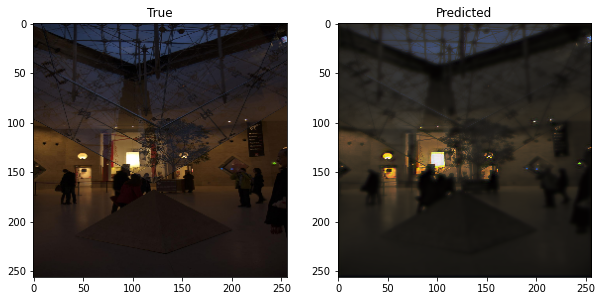

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Filename: a0504-jmacIMG_6809.JPG


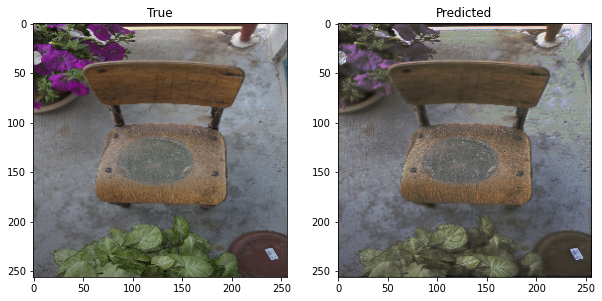

In [6]:
test_batch = next(iter(test_dataset.data))
for i in range(len(test_batch['filename'])):
    test_logits = model(test_batch['sRGB_image'])
    print("Filename:", test_batch['filename'][i].numpy().decode())
    fig, ax = plt.subplots(1, 2, figsize=(10, 10))
    ax[0].imshow(test_batch['sRGB_image'][i].numpy())
    ax[1].imshow(test_logits[1][i].numpy())
    ax[0].set_title("True")
    ax[1].set_title("Predicted")
    plt.show()

## XYZ

Filename: a1776-dgw_142.JPG


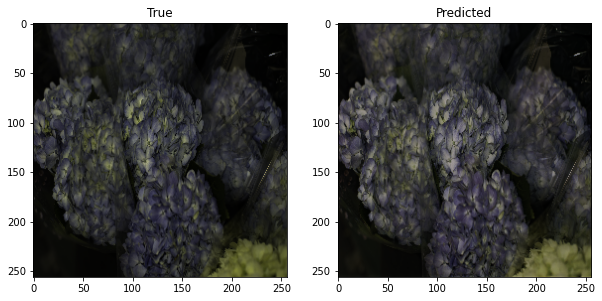

Filename: a1656-dvf_005.JPG


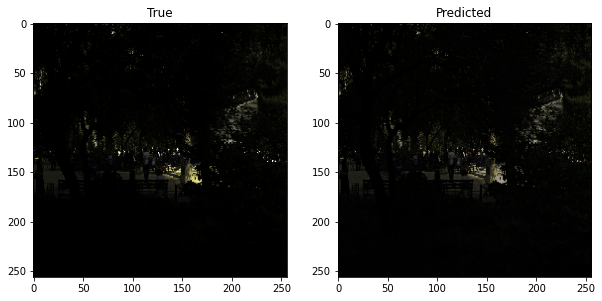

Filename: a0416-IMG_2389.JPG


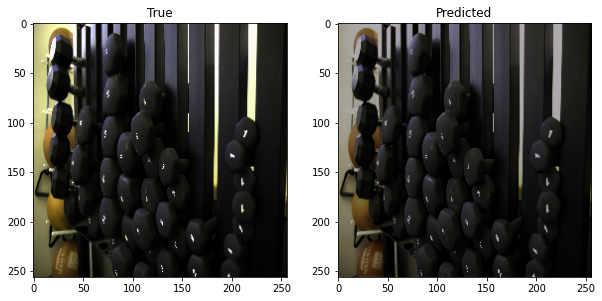

Filename: a1952-07-12-02-at-12h24m10s-_MG_8944.JPG


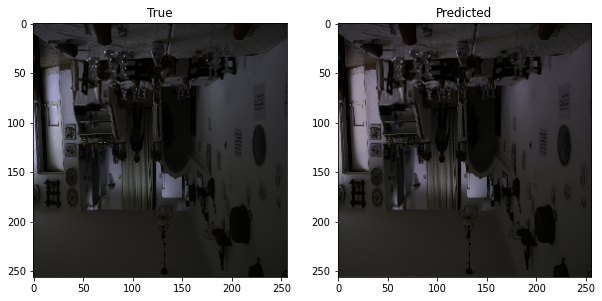

In [7]:
test_batch = next(iter(test_dataset.data))
for i in range(len(test_batch['filename'])):
    test_logits = model(test_batch['sRGB_image'])
    print("Filename:", test_batch['filename'][i].numpy().decode())
    fig, ax = plt.subplots(1, 2, figsize=(10, 10))
    ax[0].imshow(test_batch['XYZ_image'][i].numpy())
    ax[1].imshow(test_logits[0][i].numpy())
    ax[0].set_title("True")
    ax[1].set_title("Predicted")
    plt.show()